<a href="https://colab.research.google.com/github/jodfedlet/TCC/blob/main/TCCII/Twitter/preprocessing_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importando/instalando bibliotecas

In [ ]:
!pip install unidecode
import pandas as pd
import numpy as np
import nltk
import re
import spacy
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from google.colab import drive
drive.mount("/content/drive")
nltk.download('all-corpora')
nltk.download('punkt')
nltk.download('rslp')

!python3 -m spacy download pt

from nltk.corpus import stopwords
from unidecode import unidecode
from matplotlib import cm

# Carregamento dos tweets até dezembro de 2021

In [544]:
#tweets_orig = pd.read_csv('/content/drive/My Drive/ColabNotebooks/tweets_until_dec_2021.csv', lineterminator='\n', index_col=0)

tweets_orig = pd.read_csv('/content/drive/My Drive/ColabNotebooks/all_tweets.csv', lineterminator='\n', index_col=0)

#Estatística dos tweets

In [545]:
def tweets_stats(df):
  print('Total of tweets: '+str(len(df)))
  df['datetime'] = pd.to_datetime(df.datetime, format='%Y-%m-%d %H:%M:%S')

  #data by year
  def plot_by_year(): 
    by_year = df.groupby([df['datetime'].dt.year.rename('Year')]).size().reset_index(name='Total')

    # color map based on years
    yrs = np.unique(by_year.Year)
    c = cm.get_cmap('tab20', len(yrs))
    ## probably a more elegant way to do this...
    yrClr = np.zeros((len(by_year.Year),4))
    for i, v in enumerate(yrs): 
        yrClr[by_year.Year==v,:]=c.colors[i,:]
    
    fig, ax = plt.subplots(figsize=(30,4))
    by_year.plot(kind='bar', x='Year', y='Total', color=yrClr, title="Tweets by year", ax=ax)

    for index, value in enumerate(list(by_year["Total"])):
      plt.text(index, value, str(value))

    ax.set_xlabel('Year')
    ax.set_ylabel('Count')

    plt.show()
  

  #by year month
  def plot_by_year_and_month():
    by_year_month = df.groupby([df['datetime'].dt.year.rename('Year'), df['datetime'].dt.month.rename('Month')]).size().reset_index(name='Total')

    # color map based on years
    yrs = np.unique(by_year_month.Year)
    c = cm.get_cmap('tab20', len(yrs))
    ## probably a more elegant way to do this...
    yrClr = np.zeros((len(by_year_month.Year),4))
    for i, v in enumerate(yrs): 
        yrClr[by_year_month.Year==v,:]=c.colors[i,:]

    fig, axs = plt.subplots(figsize=(30, 4))
    by_year_month['MonthYr'] = pd.to_datetime(by_year_month.assign(day=1)[['Year','Month','day']]).dt.strftime('%m-%Y')
    by_year_month.plot(kind='bar', x='MonthYr', y='Total', color=yrClr, title="Tweets by year and month", ax=axs)

    for index, value in enumerate(list(by_year_month["Total"])):
      plt.text(index - .2, value, str(value))

    axs.set_xlabel('Month - Year')
    axs.set_ylabel('Count')

  plot_by_year()
  plot_by_year_and_month()

###Estatística dos tweets antes do pré-processamento:

Total of tweets: 185222


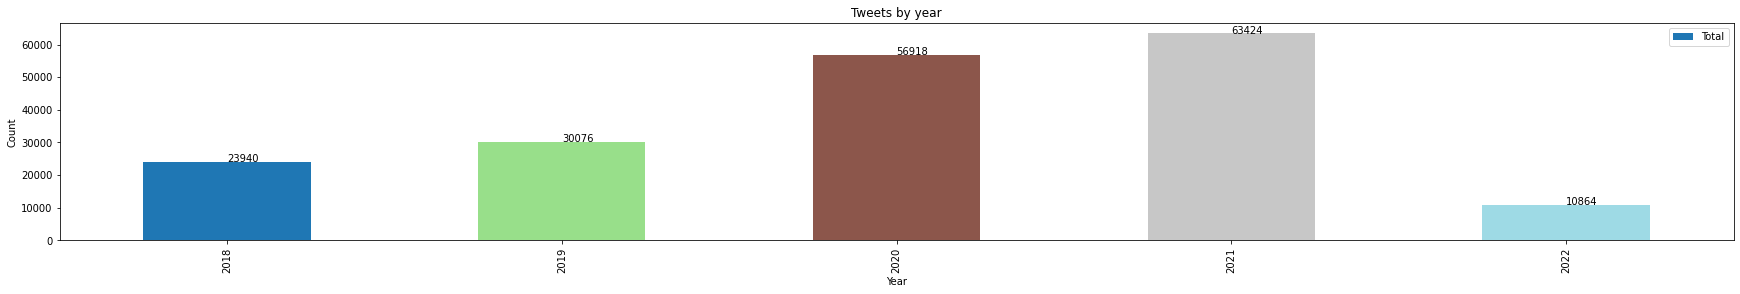

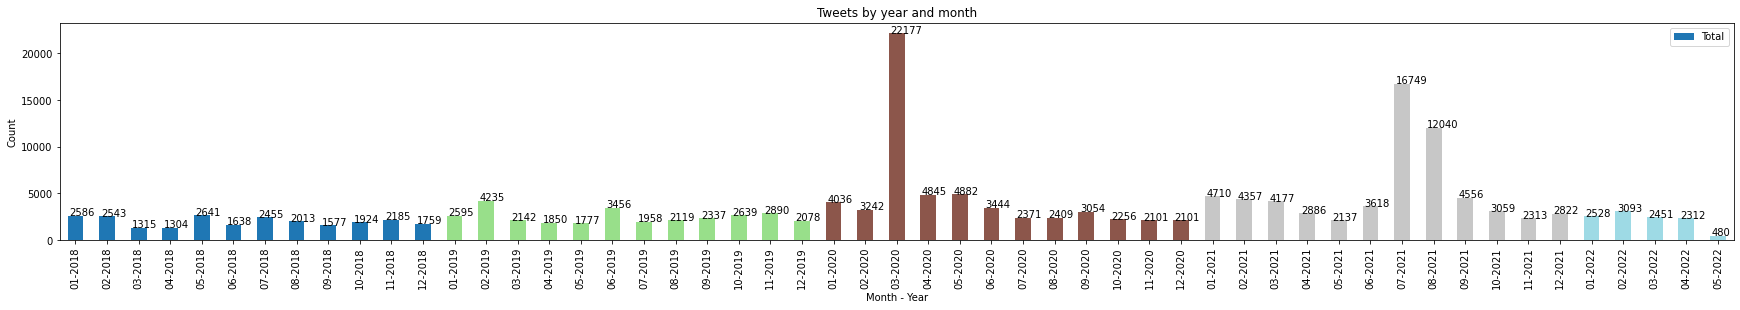

In [546]:
tweets_stats(tweets_orig)

#Quantidade de tweets


In [547]:
tweets_orig.shape

(185222, 4)

In [548]:
tweets_orig.text.head().tolist()

['E pensar que esse lixo ganhou projeção com a estapafúrdia missão Brasileirão no Haiti https://t.co/Jb5gDlHzUk',
 'nem recebi e já tô duro🤣🤣🤬',
 'missão no Haiti https://t.co/8jT65Pw4aP',
 '@gen_heleno O sr foi expulso de uma missão de paz no Haiti. Estou certo? Enaltece ditaduras, quem és tu pra falar mau de um hino comunista?',
 '@gen_heleno A memória dos brasileiros está intacta,lembramos do Golpe de 64 o regime da Ditadura e seus Assassinatos Torturas Desaparecimentos,a farta Roubalheira dos militares e Lembramos muito bem do Haiti e dos Roubos no COB , também lembramos do golpe de 2016 e a fraude eleitoral 2018 !']

In [549]:
tweets_orig.text.tolist()

['E pensar que esse lixo ganhou projeção com a estapafúrdia missão Brasileirão no Haiti https://t.co/Jb5gDlHzUk',
 'nem recebi e já tô duro🤣🤣🤬',
 'missão no Haiti https://t.co/8jT65Pw4aP',
 '@gen_heleno O sr foi expulso de uma missão de paz no Haiti. Estou certo? Enaltece ditaduras, quem és tu pra falar mau de um hino comunista?',
 '@gen_heleno A memória dos brasileiros está intacta,lembramos do Golpe de 64 o regime da Ditadura e seus Assassinatos Torturas Desaparecimentos,a farta Roubalheira dos militares e Lembramos muito bem do Haiti e dos Roubos no COB , também lembramos do golpe de 2016 e a fraude eleitoral 2018 !',
 '@cartacapital prestigiaram mesmo, mandaram o heleno comandar o genocídio haitiano a mando dos EUA e OTAN https://t.co/ArHUy7s1MB',
 '@gen_heleno Lá no Haiti o mal tem seu sobrenome.',
 '@gen_heleno Tens que responder teu BO no Haiti, onde acusam tua tropa de assassinatos, estupros etc...',
 '@gen_heleno Talvez a Time deveria relembrar o episódio do Haiti.',
 '@gen_he

#Pegar os stop words da língua portuguesa usando NLTK

In [550]:
stop_words = set(stopwords.words('portuguese'))

In [551]:
type(stop_words)


set

In [552]:
stop_words

{'a',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'estamos',
 'estas',
 'estava',
 'estavam',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéramos',
 'estivéssemos',
 'estou',
 'está',
 'estávamos',
 'estão',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fui',
 'fôramos',
 'fôssemos',
 'haja',
 'hajam',
 'hajamos',
 'havemos',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houveram',
 'houverei',
 'houverem',
 'houveremos',
 'houveria',
 'houveriam',
 'houvermos',
 'houverá',
 'houverão',
 'houveríamos',
 'houvesse',


#Pré-processamento dos tweets

###Função para limpar os tweets

In [553]:
def pre_processing_tweets(tweet):
  tweet_list = str(tweet).lower().split()
 
  #remover palavras que iniciam com @, #, stopwords ou com tamanho < 2 se forem diferentes de ht.
  def remove_undesirable_words(tweet_list):
      new_list_ = []
      for token in tweet_list:
         if token.startswith('@') or token.startswith('#') or token in stop_words or (len(token) < 3 and token != 'ht'): continue
         new_list_.append(remove_emphasis(token))
      return new_list_

  #remover acentuações
  def remove_emphasis(token):
      return unidecode(token)

  #remover urls
  def remove_url(tweet_without_sw):
      return re.sub(r"http\S+", "", tweet_without_sw)

  #remover pontuações
  def remove_punctuation(tweet):
      return re.sub(r'[^\w\s]','',tweet)

  #remover palavras que contem ou que são números
  def remove_numeric(tweet):
     return ' '.join([token for token in tweet.split() if not token.isdigit() and not any(map(str.isdigit, token))])    

  tweet_list = remove_undesirable_words(tweet_list)
  tweet = remove_url(' '.join(tweet_list))
  tweet = remove_punctuation(tweet)
  tweet = remove_numeric(tweet)
  return ' '.join(remove_undesirable_words(tweet.split()))
 


###Exemplo de tweet antes da aplicação da função de pré-procesamento

In [554]:
string_example = "@gen_heleno VAI BOTAR UM PIJAMA???? This dog 😂😂😂😂 E VAI PRA CASA DESCANSAR no ht vc.  REZA456 E PEÇA A DEUS QUE PERDOE TODAS AS BARBARIDADES QUE VOCÊ COMETEU NO HAITI em 2015. EXISTEM ALMAS LÁ QUE NUNCA IRÃO PERDOAR AS SUAS ATITUDES. VOCÊ E DEUS SABEM DISTO."

In [555]:
string_example

'@gen_heleno VAI BOTAR UM PIJAMA???? This dog 😂😂😂😂 E VAI PRA CASA DESCANSAR no ht vc.  REZA456 E PEÇA A DEUS QUE PERDOE TODAS AS BARBARIDADES QUE VOCÊ COMETEU NO HAITI em 2015. EXISTEM ALMAS LÁ QUE NUNCA IRÃO PERDOAR AS SUAS ATITUDES. VOCÊ E DEUS SABEM DISTO.'

In [556]:
filtered_tweet = pre_processing_tweets(string_example)

###Exemplo de tweet depois da aplicação da função de pré-procesamento

In [557]:
filtered_tweet

'vai botar pijama this dog vai pra casa descansar ht peca deus perdoe todas barbaridades cometeu haiti existem almas nunca irao perdoar atitudes deus sabem disto'

###Aplicação da função do pré-processamento nos tweets

In [558]:
tweets_pre_proc = tweets_orig.copy()
tweets_pre_proc['text'] = tweets_orig['text'].map(lambda tweet: pre_processing_tweets(tweet))

In [559]:
tweets_orig.text.head().tolist()

['E pensar que esse lixo ganhou projeção com a estapafúrdia missão Brasileirão no Haiti https://t.co/Jb5gDlHzUk',
 'nem recebi e já tô duro🤣🤣🤬',
 'missão no Haiti https://t.co/8jT65Pw4aP',
 '@gen_heleno O sr foi expulso de uma missão de paz no Haiti. Estou certo? Enaltece ditaduras, quem és tu pra falar mau de um hino comunista?',
 '@gen_heleno A memória dos brasileiros está intacta,lembramos do Golpe de 64 o regime da Ditadura e seus Assassinatos Torturas Desaparecimentos,a farta Roubalheira dos militares e Lembramos muito bem do Haiti e dos Roubos no COB , também lembramos do golpe de 2016 e a fraude eleitoral 2018 !']

In [560]:
tweets_pre_proc.text.head().tolist()

['pensar lixo ganhou projecao estapafurdia missao brasileirao haiti',
 'recebi duro',
 'missao haiti',
 'expulso missao paz haiti certo enaltece ditaduras pra falar mau hino comunista',
 'memoria brasileiros intactalembramos golpe regime ditadura assassinatos torturas desaparecimentosa farta roubalheira militares lembramos bem haiti roubos cob lembramos golpe fraude eleitoral']

###Remover tweets com menos de 3 palavras

In [561]:
tweets_pre_proc = tweets_pre_proc.loc[tweets_pre_proc['text'].str.split().str.len() > 3]

In [562]:
tweets_pre_proc.shape

(170184, 4)

###Remover os tweets duplicados

In [563]:
tweets_pre_proc.drop_duplicates(subset = ["text"], keep='first', inplace=True)

###Quantidade de tweets após a remoção dos tweets duplicados

In [564]:
tweets_pre_proc.shape

(149303, 4)

In [565]:
tweets_orig.text.head().tolist()

['E pensar que esse lixo ganhou projeção com a estapafúrdia missão Brasileirão no Haiti https://t.co/Jb5gDlHzUk',
 'nem recebi e já tô duro🤣🤣🤬',
 'missão no Haiti https://t.co/8jT65Pw4aP',
 '@gen_heleno O sr foi expulso de uma missão de paz no Haiti. Estou certo? Enaltece ditaduras, quem és tu pra falar mau de um hino comunista?',
 '@gen_heleno A memória dos brasileiros está intacta,lembramos do Golpe de 64 o regime da Ditadura e seus Assassinatos Torturas Desaparecimentos,a farta Roubalheira dos militares e Lembramos muito bem do Haiti e dos Roubos no COB , também lembramos do golpe de 2016 e a fraude eleitoral 2018 !']

In [566]:
tweets_pre_proc.text.head().tolist()

['pensar lixo ganhou projecao estapafurdia missao brasileirao haiti',
 'expulso missao paz haiti certo enaltece ditaduras pra falar mau hino comunista',
 'memoria brasileiros intactalembramos golpe regime ditadura assassinatos torturas desaparecimentosa farta roubalheira militares lembramos bem haiti roubos cob lembramos golpe fraude eleitoral',
 'prestigiaram mandaram heleno comandar genocidio haitiano mando eua otan',
 'tens responder haiti onde acusam tropa assassinatos estupros etc']

###Estatística dos tweets após o pré-processamento:

Total of tweets: 149303


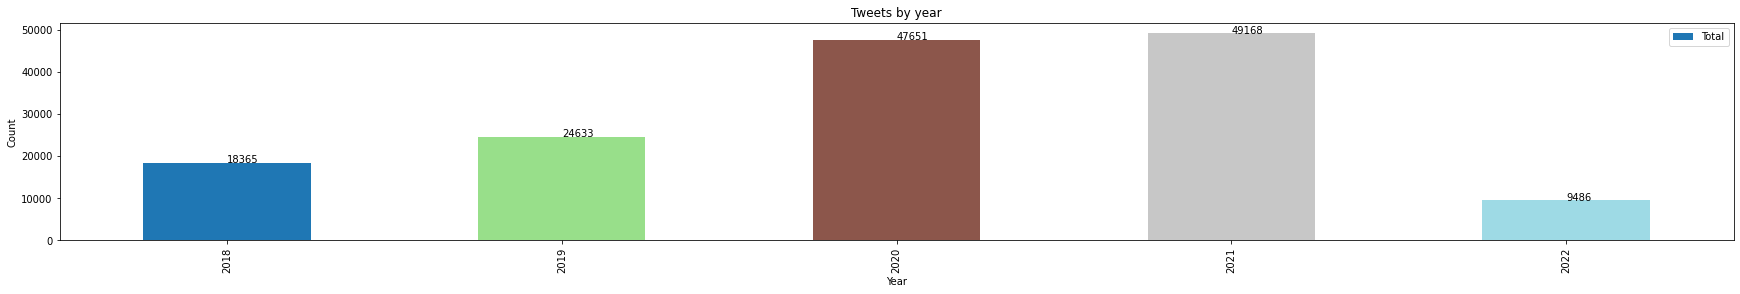

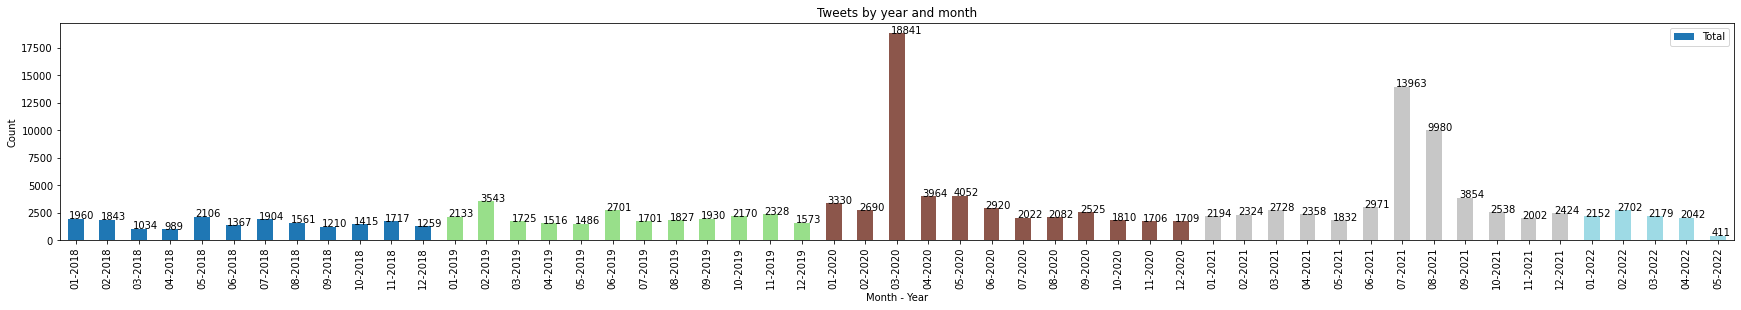

In [567]:
tweets_stats(tweets_pre_proc)

#Lematização e stemização

In [568]:
pln = spacy.load('pt')

###Lematização

In [569]:
string_lem_example = 'capacetes brancos ajudaram haiti pare besteira ajudou haiti fim exercito capacetes brancos resolvem problema presos campos concentracao argentina criou'

In [570]:
def lemmatization(tweet):
  document = pln(tweet)
  return ' '.join([token.lemma_ for token in document])

In [571]:
tweet_lem_example = lemmatization(string_lem_example)

In [572]:
tweet_lem_example

'capacete branco ajudar haiti parir besteira ajudar haiti fim exercitar capacete branco resolver problema preso campo concentracao argentino criar'

In [573]:
tweets_lemm = tweets_pre_proc.copy()
tweets_lemm['text'] = tweets_pre_proc['text'].map(lambda tweet: lemmatization(tweet))

In [574]:
tweets_lemm.text.head().tolist()

['pensar lixar ganhar projecao estapafurdia missao brasileirao haiti',
 'expulsar missao paz haiti certar enaltecer ditadura pra falar mau hino comunista',
 'memoriar brasileiro intactalembramos golpe regime ditadura assassinato torturar desaparecimentosa farto roubalheira militar lembrar bem haiti roubo cob lembrar golpe fraudar eleitoral',
 'prestigiar mandar heleno comandar genocidio haitiano mandar eua otan',
 'ter responder haiti onde acusar tropa assassinato estupro etc']

###Stematização

In [575]:
string_stem_example = 'capacetes brancos ajudaram haiti pare besteira ajudou haiti fim exercito capacetes brancos resolvem problema presos campos concentracao argentina criou'

In [576]:
def stemming(tweet):
  document = pln(tweet)
  stemmer = nltk.stem.RSLPStemmer()
  return ' '.join([stemmer.stem(token.text) for token in document])

In [577]:
string_stem_example = stemming(string_stem_example)

In [578]:
string_stem_example

'capacet branc ajud hait par beste ajud hait fim exercit capacet branc resolv problem pres camp concentraca argentin cri'

In [579]:
tweets_stem = tweets_pre_proc.copy()
tweets_stem['text'] = tweets_pre_proc['text'].map(lambda tweet: stemming(tweet))

In [580]:
tweets_stem.text.head().tolist()

['pens lix ganh projeca estapafurd missa brasileira hait',
 'expuls missa paz hait cert enaltec ditad pra fal mau hin comun',
 'memor brasil intactalembr golp regim ditad assassinat tort desapareciment fart roubalh milit lembr bem hait roub cob lembr golp fraud eleitor',
 'prestigi mand helen comand genocidi haiti mand eua otan',
 'tem respond hait ond acus trop assassinat estupr etc']

#Comparação de tweets originais, pré-processados, lematizados e stematizados

###Tweets originais

In [581]:
tweets_orig.text.head().tolist()

['E pensar que esse lixo ganhou projeção com a estapafúrdia missão Brasileirão no Haiti https://t.co/Jb5gDlHzUk',
 'nem recebi e já tô duro🤣🤣🤬',
 'missão no Haiti https://t.co/8jT65Pw4aP',
 '@gen_heleno O sr foi expulso de uma missão de paz no Haiti. Estou certo? Enaltece ditaduras, quem és tu pra falar mau de um hino comunista?',
 '@gen_heleno A memória dos brasileiros está intacta,lembramos do Golpe de 64 o regime da Ditadura e seus Assassinatos Torturas Desaparecimentos,a farta Roubalheira dos militares e Lembramos muito bem do Haiti e dos Roubos no COB , também lembramos do golpe de 2016 e a fraude eleitoral 2018 !']

### Tweets pré-processados

In [582]:
tweets_pre_proc.text.head().tolist()

['pensar lixo ganhou projecao estapafurdia missao brasileirao haiti',
 'expulso missao paz haiti certo enaltece ditaduras pra falar mau hino comunista',
 'memoria brasileiros intactalembramos golpe regime ditadura assassinatos torturas desaparecimentosa farta roubalheira militares lembramos bem haiti roubos cob lembramos golpe fraude eleitoral',
 'prestigiaram mandaram heleno comandar genocidio haitiano mando eua otan',
 'tens responder haiti onde acusam tropa assassinatos estupros etc']

###Tweets lematizados

In [583]:
tweets_lemm.text.head().tolist()

['pensar lixar ganhar projecao estapafurdia missao brasileirao haiti',
 'expulsar missao paz haiti certar enaltecer ditadura pra falar mau hino comunista',
 'memoriar brasileiro intactalembramos golpe regime ditadura assassinato torturar desaparecimentosa farto roubalheira militar lembrar bem haiti roubo cob lembrar golpe fraudar eleitoral',
 'prestigiar mandar heleno comandar genocidio haitiano mandar eua otan',
 'ter responder haiti onde acusar tropa assassinato estupro etc']

###Tweets stematizados

In [584]:
tweets_stem.text.head().tolist()

['pens lix ganh projeca estapafurd missa brasileira hait',
 'expuls missa paz hait cert enaltec ditad pra fal mau hin comun',
 'memor brasil intactalembr golp regim ditad assassinat tort desapareciment fart roubalh milit lembr bem hait roub cob lembr golp fraud eleitor',
 'prestigi mand helen comand genocidi haiti mand eua otan',
 'tem respond hait ond acus trop assassinat estupr etc']

##Criando o arquivo .csv dos tweets

In [585]:
df = pd.DataFrame(tweets_pre_proc)
df.to_csv('/content/drive/My Drive/ColabNotebooks/pre_processed_tweets.csv')